In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2022-07-26 02:24:08--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.67MB/s    in 0.3s    

2022-07-26 02:24:08 (1.67 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
!ls

sample_data  spam.csv


In [5]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [6]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [7]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# Drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [11]:
# Rename columns
df.columns = ['labels', 'data']

In [12]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [14]:
Y = df['b_labels'].values

In [16]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [20]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train) # fit just training data
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [21]:
# See # of words in our vocab (word -> integer mapping)
word2idx = tokenizer.word_index
V = len(word2idx)
print("Num tokens = ", V)

Num tokens =  7253


In [23]:
# Pad sequences so that we get N x T matrix
data_train = pad_sequences(sequences_train) # pads beginning
print("Shape of data train tensor =", data_train.shape)

T = data_train.shape[1]

Shape of data train tensor = (3733, 162)


In [24]:
# maxlen is T...if test set has longer sentences, they may be truncated. but we need a maxlen value
data_test = pad_sequences(sequences_test, maxlen=T)
print("Shape of data test tensor =", data_test.shape)

Shape of data test tensor = (1839, 162)


In [26]:
# Create the model
D = 20 # we choose embedding dimensionality (hyperparameter)
M = 15 # hidden state dimensionality

# input takes sequence of integers (size T)
i = Input(shape=(T,))
# embedding takes sequence of integers and returns sequence of word vectors
# output is an N x T x D array (suitable for RNN structure)
# since first word index is 1, and we have 0 indexing in python, we need V + 1
x = Embedding(V + 1, D)(i) 
# LSTM with returned sequences and global max pooling was shown to work nicely for learning long term dependencies
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
# binary classification
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [27]:
# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    data_train,
    Ytrain,
    epochs=10,
    validation_data=(data_test, Ytest)
)

Epoch 1/10
117/117 [==============================] - 21s 132ms/step - loss: 0.4592 - accuracy: 0.8669 - val_loss: 0.3979 - val_accuracy: 0.8641
Epoch 2/10
117/117 [==============================] - 14s 116ms/step - loss: 0.3922 - accuracy: 0.8669 - val_loss: 0.3966 - val_accuracy: 0.8641
Epoch 3/10
117/117 [==============================] - 13s 115ms/step - loss: 0.3907 - accuracy: 0.8669 - val_loss: 0.3940 - val_accuracy: 0.8641
Epoch 4/10
117/117 [==============================] - 12s 99ms/step - loss: 0.3831 - accuracy: 0.8669 - val_loss: 0.3794 - val_accuracy: 0.8641
Epoch 5/10
117/117 [==============================] - 14s 120ms/step - loss: 0.3263 - accuracy: 0.8669 - val_loss: 0.2579 - val_accuracy: 0.8641
Epoch 6/10
117/117 [==============================] - 14s 121ms/step - loss: 0.1939 - accuracy: 0.9239 - val_loss: 0.1557 - val_accuracy: 0.9668
Epoch 7/10
117/117 [==============================] - 15s 125ms/step - loss: 0.1088 - accuracy: 0.9853 - val_loss: 0.1079 - val_acc

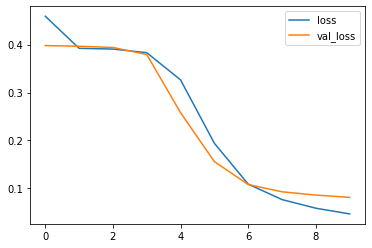

In [28]:
# very nice results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

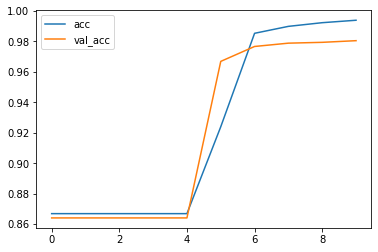

In [29]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()